In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import IPython
import IPython.display

2023-02-20 15:52:56.685147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 15:52:57.295939: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-20 15:52:58.837523: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda-11.7/lib64:
2023-02-20 15:52:58.840555: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

## Récupération des données

In [2]:
columns = ["Date", "Heure", "SG Hauteur", "SG Ectype", "SG Q", "SN Hauteur", "SN Ectype", "SN Q",
          "Montoir Hauteur", "Montoir Ectype", "Montoir Q", "Paimboeuf Hauteur", "Paimboeuf Ectype", "Paimboeuf Q",
          "Cordemais Hauteur", "Cordemais Ectype", "Cordemais Q", "LP Hauteur", "LP Ectype", "LP Q",
          "NUB Hauteur", "NUB Ectype", "NUB Q", "NSAL Hauteur", "NSAL Ectype", "NSAL Q", "SG Patm", "Nantes Patm"]

chunks = pd.read_csv("Datas/X_tides.csv", index_col=0, chunksize = 1e6, iterator = True, low_memory = False)
X = pd.DataFrame()
for chunk in chunks:
    X = pd.concat((X,chunk))

print(X)
X.pop('Date')

                        Date  NSAL Hauteur (t-48)  NSAL Hauteur (t-47)  \
48       2012-01-01 04:00:00                 4.68                 4.64   
49       2012-01-01 04:05:00                 4.64                 4.61   
50       2012-01-01 04:10:00                 4.61                 4.57   
51       2012-01-01 04:15:00                 4.57                 4.54   
52       2012-01-01 04:20:00                 4.54                 4.51   
...                      ...                  ...                  ...   
1050182  2022-12-31 23:15:00                 2.86                 2.83   
1050183  2022-12-31 23:20:00                 2.83                 2.81   
1050184  2022-12-31 23:25:00                 2.81                 2.78   
1050185  2022-12-31 23:30:00                 2.78                 2.76   
1050186  2022-12-31 23:35:00                 2.76                 2.74   

         NSAL Hauteur (t-46)  NSAL Hauteur (t-45)  NSAL Hauteur (t-44)  \
48                      4.61         

48         2012-01-01 04:00:00
49         2012-01-01 04:05:00
50         2012-01-01 04:10:00
51         2012-01-01 04:15:00
52         2012-01-01 04:20:00
                  ...         
1050182    2022-12-31 23:15:00
1050183    2022-12-31 23:20:00
1050184    2022-12-31 23:25:00
1050185    2022-12-31 23:30:00
1050186    2022-12-31 23:35:00
Name: Date, Length: 990116, dtype: object

In [3]:
chunks = pd.read_csv("Datas/Y_tides.csv", index_col=0, chunksize = 1e6, iterator = True, low_memory = False)
Y = pd.DataFrame()
for chunk in chunks:
    Y = pd.concat((Y,chunk))

print(Y)
Y.pop('Date')

                        Date  NSAL Hauteur (t)  NSAL Hauteur (t+1)  \
48       2012-01-01 04:00:00              3.44                3.40   
49       2012-01-01 04:05:00              3.40                3.36   
50       2012-01-01 04:10:00              3.36                3.32   
51       2012-01-01 04:15:00              3.32                3.27   
52       2012-01-01 04:20:00              3.27                3.24   
...                      ...               ...                 ...   
1050182  2022-12-31 23:15:00              5.54                5.58   
1050183  2022-12-31 23:20:00              5.58                5.62   
1050184  2022-12-31 23:25:00              5.62                5.64   
1050185  2022-12-31 23:30:00              5.64                5.66   
1050186  2022-12-31 23:35:00              5.66                5.68   

         NSAL Hauteur (t+2)  NSAL Hauteur (t+3)  NSAL Hauteur (t+4)  \
48                     3.36                3.32                3.27   
49               

48         2012-01-01 04:00:00
49         2012-01-01 04:05:00
50         2012-01-01 04:10:00
51         2012-01-01 04:15:00
52         2012-01-01 04:20:00
                  ...         
1050182    2022-12-31 23:15:00
1050183    2022-12-31 23:20:00
1050184    2022-12-31 23:25:00
1050185    2022-12-31 23:30:00
1050186    2022-12-31 23:35:00
Name: Date, Length: 990116, dtype: object

### Longueur d'entrée et de sortie

In [5]:
# Ces longueurs sont définies par les fichiers .csv
input_length = 48
output_length = 6

### Réorganisation des données

In [6]:
# Input features
Nb_features = int(X.shape[1]/input_length)
print(f"Number of features : {Nb_features}")

Nb_labels = int(Y.shape[1]/output_length)
print(f"Number of Label : {Nb_labels}")

Number of features : 1
Number of Label : 1


In [7]:
print(X.head)
print(Y.head)

X_datas = X.values
X_datas = X_datas.reshape((X.shape[0], input_length, Nb_features), order = 'F')
Y_datas = Y.values
Y_datas = Y_datas.reshape((Y.shape[0], output_length, Nb_labels), order ='F')

<bound method NDFrame.head of          NSAL Hauteur (t-48)  NSAL Hauteur (t-47)  NSAL Hauteur (t-46)  \
48                      4.68                 4.64                 4.61   
49                      4.64                 4.61                 4.57   
50                      4.61                 4.57                 4.54   
51                      4.57                 4.54                 4.51   
52                      4.54                 4.51                 4.48   
...                      ...                  ...                  ...   
1050182                 2.86                 2.83                 2.81   
1050183                 2.83                 2.81                 2.78   
1050184                 2.81                 2.78                 2.76   
1050185                 2.78                 2.76                 2.74   
1050186                 2.76                 2.74                 2.74   

         NSAL Hauteur (t-45)  NSAL Hauteur (t-44)  NSAL Hauteur (t-43)  \
48     

In [8]:
n = len(X_datas)
# Train dataset
X_train = X_datas[:int(0.7*n)]
Y_train = Y_datas[:int(0.7*n)]

# Validation dataset
X_val = X_datas[int(0.7*n):int(0.9*n)]
Y_val = Y_datas[int(0.7*n):int(0.9*n)]

# Test dataset
X_test = X_datas[int(0.9*n):]
Y_test = Y_datas[int(0.9*n):]

X_train

array([[[4.68],
        [4.64],
        [4.61],
        ...,
        [3.56],
        [3.52],
        [3.48]],

       [[4.64],
        [4.61],
        [4.57],
        ...,
        [3.52],
        [3.48],
        [3.44]],

       [[4.61],
        [4.57],
        [4.54],
        ...,
        [3.48],
        [3.44],
        [3.4 ]],

       ...,

       [[1.53],
        [1.66],
        [1.82],
        ...,
        [5.33],
        [5.33],
        [5.34]],

       [[1.66],
        [1.82],
        [1.97],
        ...,
        [5.33],
        [5.34],
        [5.34]],

       [[1.82],
        [1.97],
        [2.12],
        ...,
        [5.34],
        [5.34],
        [5.36]]])

In [9]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                             X: 370.1 MiB
                         chunk: 124.6 MiB
                            __: 79.3 MiB
                           ___: 79.3 MiB
                            _2: 79.3 MiB
                            _3: 79.3 MiB
                             Y: 52.9 MiB
                           _i2:  681.0 B
                           _i9:  587.0 B
                            _i:  328.0 B


### Création du modèle

In [12]:
multi_conv_model = tf.keras.Sequential([
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(3), input_shape = (input_length, Nb_features)),
    tf.keras.layers.Flatten(),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(output_length*Nb_labels,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([output_length, Nb_labels])
])
multi_conv_model.summary()

2023-02-19 14:48:19.031455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 32)            704       
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dense (Dense)               (None, 21)                14805     
                                                                 
 reshape (Reshape)           (None, 3, 7)              0         
                                                                 
Total params: 15,509
Trainable params: 15,509
Non-trainable params: 0
_________________________________________________________________


2023-02-19 14:48:19.145051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-19 14:48:19.145725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-19 14:48:19.154108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 14:48:19.156857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [10]:
multi_lstm_model =  tf.keras.Sequential([
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.LSTM(128, activation='tanh', input_shape = (input_length, Nb_features)),
    #tf.keras.layers.Dropout(0.2),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(output_length*Nb_labels, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([output_length, Nb_labels])
])
multi_lstm_model.summary()

2023-02-20 15:53:36.127448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-20 15:53:36.223560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-20 15:53:36.223886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-20 15:53:36.225243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
 reshape (Reshape)           (None, 6, 1)              0         
                                                                 
Total params: 67,334
Trainable params: 67,334
Non-trainable params: 0
_________________________________________________________________


### Compilation

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=2,
                                                mode='min')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0001)


multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()])


### Entrainement

In [ ]:
MAX_EPOCHS = 100
history = multi_lstm_model.fit(X_train, Y_train, epochs=MAX_EPOCHS, callbacks=[early_stopping, reduce_lr], batch_size = 2048, validation_data=(X_val, Y_val))

2023-02-20 15:53:41.822857: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 133071552 exceeds 10% of free system memory.
2023-02-20 15:53:41.999572: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 133071552 exceeds 10% of free system memory.


Epoch 1/100


2023-02-20 15:53:48.793333: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700


339/339 [==============================] - 24s 47ms/step - loss: 3.8602 - mean_absolute_error: 1.2325 - val_loss: 1.7889 - val_mean_absolute_error: 0.4549 - lr: 0.0010
Epoch 2/100
339/339 [==============================] - 16s 48ms/step - loss: 1.4947 - mean_absolute_error: 0.2452 - val_loss: 1.5141 - val_mean_absolute_error: 0.1265 - lr: 0.0010
Epoch 3/100
339/339 [==============================] - 15s 45ms/step - loss: 1.4092 - mean_absolute_error: 0.1098 - val_loss: 1.5028 - val_mean_absolute_error: 0.0923 - lr: 0.0010
Epoch 4/100
339/339 [==============================] - 15s 43ms/step - loss: 1.4022 - mean_absolute_error: 0.0923 - val_loss: 1.4985 - val_mean_absolute_error: 0.0837 - lr: 0.0010
Epoch 5/100
339/339 [==============================] - 14s 43ms/step - loss: 1.3997 - mean_absolute_error: 0.0856 - val_loss: 1.4973 - val_mean_absolute_error: 0.0821 - lr: 0.0010
Epoch 6/100
225/339 [==================>...........] - ETA: 4s - loss: 1.4501 - mean_absolute_error: 0.0835

In [ ]:
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label = "Validation loss")

plt.legend()
plt.show()

In [68]:
multi_lstm_model.save("models/MultiLSTM", save_format="h5")

In [17]:
multi_lstm_model.evaluate(X_test, Y_test)

619/619 [==============================] - 7s 11ms/step - loss: 15.6965 - mean_absolute_error: 0.2440


[15.696492195129395, 0.2440403699874878]

In [18]:
test = np.array([X_train[0]])
real = np.array([Y_train[0]])
test

array([[[3.96, 4.08, 4.09, 4.06, 4.26, 4.53, 4.68],
        [3.94, 4.07, 4.07, 4.06, 4.23, 4.5 , 4.64],
        [3.93, 4.05, 4.06, 4.05, 4.22, 4.47, 4.61],
        [3.91, 4.03, 4.03, 4.04, 4.19, 4.44, 4.57],
        [3.89, 4.02, 4.02, 4.02, 4.18, 4.4 , 4.54],
        [3.87, 4.  , 4.01, 4.01, 4.16, 4.38, 4.51],
        [3.85, 3.98, 3.99, 3.99, 4.15, 4.35, 4.48],
        [3.82, 3.98, 3.98, 3.97, 4.14, 4.33, 4.45],
        [3.79, 3.96, 3.96, 3.96, 4.13, 4.31, 4.43],
        [3.76, 3.93, 3.96, 3.94, 4.12, 4.29, 4.4 ],
        [3.72, 3.92, 3.95, 3.93, 4.09, 4.27, 4.38],
        [3.7 , 3.89, 3.93, 3.92, 4.08, 4.26, 4.36],
        [3.67, 3.86, 3.92, 3.92, 4.06, 4.24, 4.33],
        [3.63, 3.83, 3.89, 3.91, 4.04, 4.22, 4.32],
        [3.59, 3.81, 3.87, 3.9 , 4.02, 4.19, 4.3 ],
        [3.56, 3.77, 3.84, 3.89, 4.01, 4.17, 4.28],
        [3.52, 3.72, 3.81, 3.87, 3.99, 4.16, 4.26],
        [3.46, 3.69, 3.77, 3.84, 3.97, 4.14, 4.25],
        [3.41, 3.66, 3.74, 3.82, 3.97, 4.12, 4.22],
        [3.3

In [19]:
pred = multi_lstm_model.predict(test)

1/1 [==============================] - 1s 563ms/step


In [20]:
pred

array([[[3.2329204, 3.422517 , 3.4929714, 3.521007 , 3.7578907,
         3.9609776, 4.0285573],
        [3.2004554, 3.387924 , 3.458401 , 3.5200045, 3.7409403,
         3.944375 , 4.068955 ],
        [3.1562884, 3.3535602, 3.426627 , 3.47729  , 3.7209642,
         3.9279861, 4.04658  ]]], dtype=float32)

TypeError: subplot() takes 1 or 3 positional arguments but 2 were given

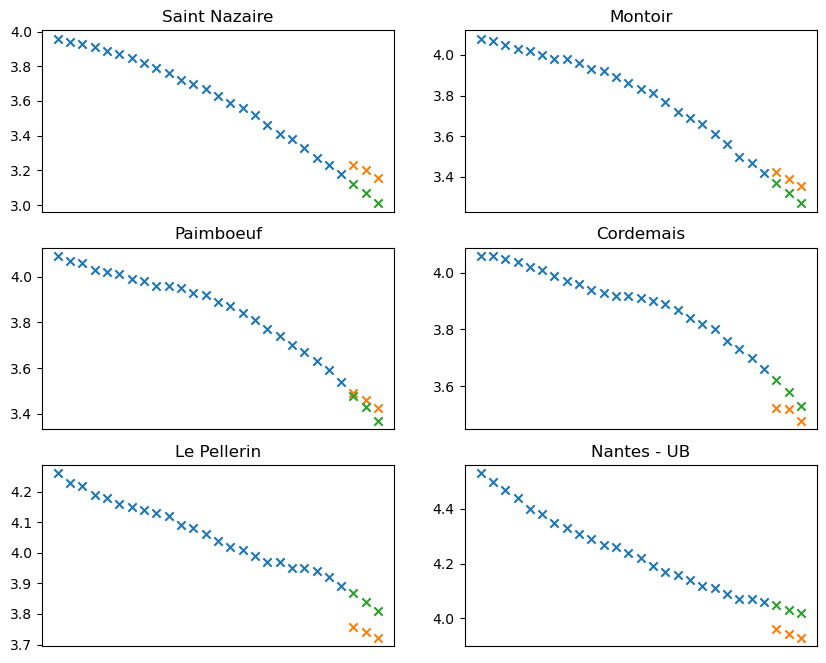

In [21]:
ports =["Saint Nazaire", "Montoir", "Paimboeuf", "Cordemais", "Le Pellerin", "Nantes - UB"]
abs = [i for i in range(input_length+output_length)]
fig, axs = plt.subplots(3,2, figsize = (10,8))
axs = axs.reshape([axs.shape[0]*axs.shape[1]])
for ax,i in zip(axs,range(pred.shape[2]-1)):
    ax.set_title(ports[i])
    ax.get_xaxis().set_visible(False)
    ax.scatter(abs[:input_length], test[0,:,i], label = "Previous steps", marker="x")
    ax.scatter(abs[input_length:], pred[0,:,i], label = "Predicted steps", marker="x")
    ax.scatter(abs[input_length:], real[0,:,i], label = "Real steps", marker="x")

handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(2,2)
ax.scatter(abs[:input_length], test[0,:,-1])


fig.legend(handles, labels, loc='upper center')
plt.show()
fig.savefig("Predictions.png")